### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle

### Data

In [3]:
experiment_name = 'PMG 287 monitoring'

In [4]:
mixture_paths = {'Saccharose hydrolysis': '../data/saccharose_hydrolysis/all.csv',
                'PMG 284 monitoring': '../data/PMG_284/seria1.csv',
                'PMG 287 monitoring': '../data/PMG_287/preprocessed_mixture_whole.csv' 
                }
#(it's ok that we are using preprocessed_mixture for PMG 287 
#cause the only preprocessing here is zeros from edges i.e. taking region: (2.952301, 10.387961))

mixture_separators = {'Saccharose hydrolysis': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

python_integrals_paths = {'Saccharose hydrolysis': '../python_integrals/',
                        'PMG 284 monitoring': '../python_integrals/',
                        'PMG 287 monitoring': '../python_integrals/'}

substances_names = {'Saccharose hydrolysis': ['saccharose', 'alpha-glucose', 'beta-glucose', 'fructose'],
                    'PMG 284 monitoring': ['2-pentene', 'triethylsilane', 'products'],
                    'PMG 287 monitoring': ['1-hexene', 'triethylsilane', 'product']
                   }

integration_intervals = {'Saccharose hydrolysis': [(5.185803, 5.246521), (5.013715, 5.056501), 
                                                   (4.419116, 4.465992), (3.776692, 3.805767)],
                    'PMG 284 monitoring': [(5.302060, 5.596931), (3.598789, 3.920281),
                                           (0.814595, 0.889757)],
                    'PMG 287 monitoring': [(3.599926, 3.679897),
                                            (4.079348, 4.129027), 
                                            (4.668059, 4.857709), 
                                            (7.616258, 7.838666), 
                                            (8.440374, 8.647265),

                                            (3.343730, 3.406997),
                                            (3.756886, 3.832615), 
                                            (6.422073, 6.564104),

                                            (3.256018, 3.343730),
                                            (3.681636, 3.722376), 
                                            (3.722376, 3.756886),
                                            (3.994139, 4.078496)
                                          ]
                   }

#### Mixture in time

In [5]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])
if experiment_name == 'Saccharose hydrolysis':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    ints = mixture_time_data = mixture_time_data.iloc[:,:-1].iloc[:,1:]
    mixture_time_data = pd.concat((ppm, ints), axis=1)
elif experiment_name == 'PMG 284 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    ints = mixture_time_data = mixture_time_data.iloc[:,:-1].iloc[:,1:]
    mixture_time_data = pd.concat((ppm, ints), axis=1)
elif experiment_name == 'PMG 287 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    ints = mixture_time_data = mixture_time_data.iloc[:,:-1].iloc[:,1:]
    mixture_time_data = pd.concat((ppm, ints), axis=1)

In [6]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]

In [7]:
mixture_time_data.columns = names

In [8]:
def load_spectrum(mixture_time_data, moment_of_time):
    ppm = mixture_time_data['ppm']
    intensity = mixture_time_data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    sp.trim_negative_intensities()
    sp.normalize()
    return sp

In [9]:
#load_spectrum(mixture_time_data, 1000).plot(profile=True)

### Baseline correction for saccharose hydrolysis

In [10]:
# if experiment_name == 'Saccharose hydrolysis':
#     for colname in ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]:
#         mixture_time_data[colname] = mixture_time_data[colname].apply(lambda x: x-0.0395)

### Integrals changing in time

In [11]:
data_cut_to_intervals = []
for interval in integration_intervals[experiment_name]:
    data_in_interval = mixture_time_data[
                                        mixture_time_data['ppm'].apply(lambda x:
                                                                               x>interval[0] and x<interval[1])
                                        ]
    data_cut_to_intervals.append(data_in_interval)

integrals_changing_in_time = []
    
for timepoint in ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]:
    
    integrals_fixed_time = []
    
    for data_in_interval in data_cut_to_intervals:
        
        x_fixed_interval = data_in_interval['ppm']
        y_fixed_interval = data_in_interval[timepoint]
        
        new_int = np.trapz(y = y_fixed_interval, x = x_fixed_interval)
        integrals_fixed_time.append(new_int)
        
    integral_entire_spectrum = np.trapz(y = mixture_time_data[timepoint], x = mixture_time_data['ppm'])
    integrals_fixed_time.append(integral_entire_spectrum)
    
    
    integrals_changing_in_time.append(integrals_fixed_time)

In [12]:
python_integrals = np.array(integrals_changing_in_time)

In [13]:
if experiment_name == 'PMG 287 monitoring':
    hexene_integral = python_integrals[:,:5].sum(axis=1).reshape(-1,1)
    triethylsilane_integral = python_integrals[:,5:8].sum(axis=1).reshape(-1,1)
    product_integral = python_integrals[:,8:12].sum(axis=1).reshape(-1,1)
    whole_integral = python_integrals[:,12:13].sum(axis=1).reshape(-1,1)
    python_integrals = np.concatenate([hexene_integral, triethylsilane_integral, product_integral, whole_integral],
                                     axis=1)

### Figures

(0.0, 0.3)

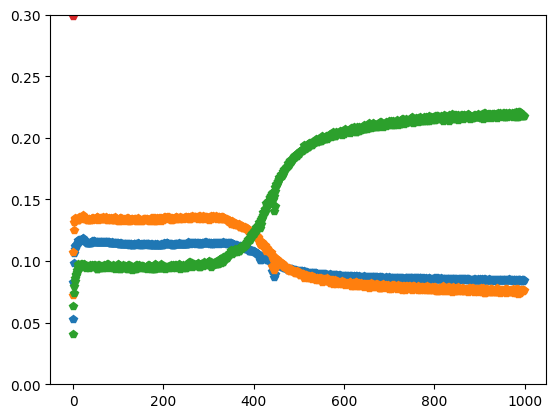

In [15]:
for i in range(python_integrals.shape[1]):
    plt.plot(python_integrals[:,i], 'p')
# plt.ylim(-0, 0.01)
# plt.ylim(-0, 0.04)
# plt.ylim(-0, 0.3)

### Saving results

In [16]:
colnames = [name + ': ' + str(interval) for name, interval in zip(substances_names[experiment_name],
                                                                integration_intervals[experiment_name])
           ]

In [17]:
python_integrals_df = pd.DataFrame(python_integrals, columns=colnames + ['whole_spectrum'])

In [18]:
python_integrals_df.to_csv(python_integrals_paths[experiment_name]+
                           'python_integral_' + 
                           '_'.join(experiment_name.split()) + 
                           '.csv',
                          index=False)